In [1]:
from sklearn.manifold import TSNE
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from torchmetrics import Accuracy, F1Score, Precision, Recall, AUROC
import pandas as pd
import numpy as np

c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [2]:
from preprocess import create_lineup_graph, add_reversed_negatives

In [3]:
df = pd.read_csv('../get_lineup_target_score/nba_with_lineup_score.csv')
pre_df = pd.read_csv('../pre_season/pre_lineup_vs_lineup.csv')
pre_player_stats_df = pd.read_csv('../../data/player_stats_2023-24.csv')

In [4]:
data = create_lineup_graph(df, pre_df, pre_player_stats_df)

In [11]:
data

Data(x=[844, 17], edge_index=[2, 696], edge_attr=[696, 1], num_nodes=844)

# Training

In [5]:
from model import LitGNN
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import DataLoader
import pytorch_lightning as pl

In [6]:
batch_size = 1
train_data, val_data, test_data = RandomLinkSplit(num_val=0.1, num_test=0.1)(data)
train_data = add_reversed_negatives(train_data)
val_data = add_reversed_negatives(val_data)
test_data = add_reversed_negatives(test_data)
train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
val_loader = DataLoader([val_data], batch_size=batch_size, shuffle=False)
test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

In [7]:
best_model_parameters = {
    'conv_layers': 2,
    'conv_hidden_dim': 64,
    'link_predictor_layers': 2,
    'link_hidden_dim': 64,
    'lr': 0.001,
    'weight_decay': 0.0001,
    'dropout': 0.5,
}

In [8]:
model = LitGNN(input_dim=data.x.shape[1])

trainer = pl.Trainer(
    max_epochs=500,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min'),
        pl.callbacks.ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min')
    ],
)

trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | gnn            | GNNModel       | 13.8 K | train
1 | link_predictor | LinkPredictor  | 8.3 K  | train
2 | loss_fn        | BCELoss        | 0      | train
3 | train_acc      | BinaryAccuracy | 0      | train
4 | va

c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 844. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s, v_num=85, train_loss=0.699, train_acc=0.496, train_auc=0.502, val_loss=0.686, val_acc=0.569, val_auc=0.705]

Metric val_loss improved. New best score: 0.686


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s, v_num=85, train_loss=0.696, train_acc=0.543, train_auc=0.572, val_loss=0.682, val_acc=0.634, val_auc=0.719]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.682


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 14.95it/s, v_num=85, train_loss=0.692, train_acc=0.581, train_auc=0.617, val_loss=0.681, val_acc=0.677, val_auc=0.720]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.681


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 19.56it/s, v_num=85, train_loss=0.687, train_acc=0.618, train_auc=0.656, val_loss=0.680, val_acc=0.711, val_auc=0.723]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.680


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s, v_num=85, train_loss=0.730, train_acc=0.676, train_auc=0.670, val_loss=0.678, val_acc=0.716, val_auc=0.728]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.678


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s, v_num=85, train_loss=0.683, train_acc=0.668, train_auc=0.678, val_loss=0.676, val_acc=0.716, val_auc=0.732]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.676


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s, v_num=85, train_loss=0.690, train_acc=0.676, train_auc=0.680, val_loss=0.674, val_acc=0.720, val_auc=0.736]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.674


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s, v_num=85, train_loss=0.667, train_acc=0.696, train_auc=0.716, val_loss=0.672, val_acc=0.720, val_auc=0.740]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.672


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 18.95it/s, v_num=85, train_loss=0.683, train_acc=0.691, train_auc=0.686, val_loss=0.669, val_acc=0.720, val_auc=0.743]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.669


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s, v_num=85, train_loss=0.678, train_acc=0.698, train_auc=0.711, val_loss=0.667, val_acc=0.717, val_auc=0.745]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.667


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 14.83it/s, v_num=85, train_loss=0.668, train_acc=0.720, train_auc=0.727, val_loss=0.664, val_acc=0.715, val_auc=0.748]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.664


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 16.86it/s, v_num=85, train_loss=0.670, train_acc=0.713, train_auc=0.721, val_loss=0.661, val_acc=0.720, val_auc=0.750]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.661


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s, v_num=85, train_loss=0.662, train_acc=0.713, train_auc=0.739, val_loss=0.657, val_acc=0.717, val_auc=0.751]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.657


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 16.73it/s, v_num=85, train_loss=0.670, train_acc=0.713, train_auc=0.722, val_loss=0.654, val_acc=0.721, val_auc=0.751]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.654


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 18.59it/s, v_num=85, train_loss=0.686, train_acc=0.714, train_auc=0.731, val_loss=0.651, val_acc=0.723, val_auc=0.751]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.651


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 20.60it/s, v_num=85, train_loss=0.704, train_acc=0.710, train_auc=0.718, val_loss=0.649, val_acc=0.724, val_auc=0.752]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.649


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 20.67it/s, v_num=85, train_loss=0.664, train_acc=0.722, train_auc=0.734, val_loss=0.647, val_acc=0.728, val_auc=0.755]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.647


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s, v_num=85, train_loss=0.673, train_acc=0.723, train_auc=0.737, val_loss=0.645, val_acc=0.728, val_auc=0.759]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.645


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 18.73it/s, v_num=85, train_loss=0.654, train_acc=0.714, train_auc=0.736, val_loss=0.642, val_acc=0.728, val_auc=0.763]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.642


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 16.94it/s, v_num=85, train_loss=0.642, train_acc=0.719, train_auc=0.747, val_loss=0.640, val_acc=0.725, val_auc=0.766]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.640


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 18.61it/s, v_num=85, train_loss=0.644, train_acc=0.728, train_auc=0.754, val_loss=0.636, val_acc=0.725, val_auc=0.769]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.636


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 20.17it/s, v_num=85, train_loss=0.636, train_acc=0.732, train_auc=0.764, val_loss=0.632, val_acc=0.727, val_auc=0.771]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.632


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 21.74it/s, v_num=85, train_loss=0.640, train_acc=0.723, train_auc=0.756, val_loss=0.628, val_acc=0.728, val_auc=0.773]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.628


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 18.98it/s, v_num=85, train_loss=0.640, train_acc=0.727, train_auc=0.765, val_loss=0.622, val_acc=0.727, val_auc=0.775]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.622


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 16.23it/s, v_num=85, train_loss=0.626, train_acc=0.726, train_auc=0.762, val_loss=0.616, val_acc=0.729, val_auc=0.778]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.616


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s, v_num=85, train_loss=0.618, train_acc=0.749, train_auc=0.773, val_loss=0.609, val_acc=0.733, val_auc=0.779]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.609


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 16.40it/s, v_num=85, train_loss=0.641, train_acc=0.731, train_auc=0.752, val_loss=0.603, val_acc=0.733, val_auc=0.782]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.603


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s, v_num=85, train_loss=0.614, train_acc=0.722, train_auc=0.758, val_loss=0.596, val_acc=0.730, val_auc=0.783]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.596


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 18.87it/s, v_num=85, train_loss=0.601, train_acc=0.742, train_auc=0.780, val_loss=0.590, val_acc=0.731, val_auc=0.784]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.590


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 19.76it/s, v_num=85, train_loss=0.605, train_acc=0.743, train_auc=0.766, val_loss=0.584, val_acc=0.734, val_auc=0.785]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.584


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s, v_num=85, train_loss=0.591, train_acc=0.747, train_auc=0.779, val_loss=0.579, val_acc=0.737, val_auc=0.787]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.579


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s, v_num=85, train_loss=0.591, train_acc=0.717, train_auc=0.768, val_loss=0.575, val_acc=0.736, val_auc=0.788]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.575


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 16.93it/s, v_num=85, train_loss=0.617, train_acc=0.721, train_auc=0.753, val_loss=0.569, val_acc=0.737, val_auc=0.791]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.569


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 20.61it/s, v_num=85, train_loss=0.590, train_acc=0.736, train_auc=0.784, val_loss=0.563, val_acc=0.735, val_auc=0.796]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.563


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 16.79it/s, v_num=85, train_loss=0.606, train_acc=0.737, train_auc=0.761, val_loss=0.559, val_acc=0.732, val_auc=0.800]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.559


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 20.06it/s, v_num=85, train_loss=0.594, train_acc=0.736, train_auc=0.779, val_loss=0.556, val_acc=0.736, val_auc=0.805]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.556


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 21.75it/s, v_num=85, train_loss=0.585, train_acc=0.718, train_auc=0.775, val_loss=0.555, val_acc=0.739, val_auc=0.810]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.555


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 19.66it/s, v_num=85, train_loss=0.584, train_acc=0.708, train_auc=0.767, val_loss=0.553, val_acc=0.737, val_auc=0.812]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.553


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  5.54it/s, v_num=85, train_loss=0.576, train_acc=0.725, train_auc=0.783, val_loss=0.552, val_acc=0.740, val_auc=0.812]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.552


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s, v_num=85, train_loss=0.580, train_acc=0.748, train_auc=0.799, val_loss=0.549, val_acc=0.741, val_auc=0.813]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.549


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 19.76it/s, v_num=85, train_loss=0.567, train_acc=0.733, train_auc=0.800, val_loss=0.545, val_acc=0.739, val_auc=0.814]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.545


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 20.52it/s, v_num=85, train_loss=0.571, train_acc=0.721, train_auc=0.794, val_loss=0.540, val_acc=0.744, val_auc=0.816]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.540


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 18.61it/s, v_num=85, train_loss=0.571, train_acc=0.728, train_auc=0.783, val_loss=0.535, val_acc=0.748, val_auc=0.819]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.535


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 19.68it/s, v_num=85, train_loss=0.547, train_acc=0.745, train_auc=0.804, val_loss=0.531, val_acc=0.749, val_auc=0.821]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.531


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 19.11it/s, v_num=85, train_loss=0.549, train_acc=0.755, train_auc=0.806, val_loss=0.527, val_acc=0.748, val_auc=0.823]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.527


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s, v_num=85, train_loss=0.571, train_acc=0.716, train_auc=0.782, val_loss=0.523, val_acc=0.747, val_auc=0.826]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.523


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 16.77it/s, v_num=85, train_loss=0.549, train_acc=0.743, train_auc=0.813, val_loss=0.519, val_acc=0.743, val_auc=0.829]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.519


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 19.34it/s, v_num=85, train_loss=0.540, train_acc=0.744, train_auc=0.815, val_loss=0.515, val_acc=0.746, val_auc=0.832]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.515


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 20.66it/s, v_num=85, train_loss=0.539, train_acc=0.749, train_auc=0.823, val_loss=0.510, val_acc=0.743, val_auc=0.836]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.510


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.44it/s, v_num=85, train_loss=0.528, train_acc=0.721, train_auc=0.812, val_loss=0.505, val_acc=0.752, val_auc=0.840]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.505


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 14.41it/s, v_num=85, train_loss=0.541, train_acc=0.728, train_auc=0.806, val_loss=0.501, val_acc=0.754, val_auc=0.843]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.501


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s, v_num=85, train_loss=0.539, train_acc=0.754, train_auc=0.818, val_loss=0.499, val_acc=0.754, val_auc=0.847]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.499


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 13.08it/s, v_num=85, train_loss=0.539, train_acc=0.730, train_auc=0.807, val_loss=0.496, val_acc=0.758, val_auc=0.850]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.496


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 15.37it/s, v_num=85, train_loss=0.521, train_acc=0.760, train_auc=0.835, val_loss=0.492, val_acc=0.760, val_auc=0.852]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.492


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s, v_num=85, train_loss=0.536, train_acc=0.738, train_auc=0.816, val_loss=0.491, val_acc=0.754, val_auc=0.854]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.491


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 21.28it/s, v_num=85, train_loss=0.515, train_acc=0.750, train_auc=0.830, val_loss=0.490, val_acc=0.755, val_auc=0.857]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.490


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 19.34it/s, v_num=85, train_loss=0.502, train_acc=0.741, train_auc=0.846, val_loss=0.487, val_acc=0.756, val_auc=0.858]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.487


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s, v_num=85, train_loss=0.531, train_acc=0.730, train_auc=0.819, val_loss=0.486, val_acc=0.752, val_auc=0.860]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.486


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s, v_num=85, train_loss=0.523, train_acc=0.765, train_auc=0.827, val_loss=0.486, val_acc=0.753, val_auc=0.861]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.486


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 18.83it/s, v_num=85, train_loss=0.506, train_acc=0.744, train_auc=0.836, val_loss=0.484, val_acc=0.759, val_auc=0.863]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.484


Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 18.72it/s, v_num=85, train_loss=0.500, train_acc=0.760, train_auc=0.849, val_loss=0.479, val_acc=0.755, val_auc=0.863]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.479


Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 16.37it/s, v_num=85, train_loss=0.488, train_acc=0.747, train_auc=0.848, val_loss=0.471, val_acc=0.756, val_auc=0.865]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.471


Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s, v_num=85, train_loss=0.498, train_acc=0.741, train_auc=0.838, val_loss=0.463, val_acc=0.757, val_auc=0.866]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.463


Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 18.89it/s, v_num=85, train_loss=0.502, train_acc=0.730, train_auc=0.833, val_loss=0.457, val_acc=0.758, val_auc=0.867]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.457


Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s, v_num=85, train_loss=0.494, train_acc=0.746, train_auc=0.840, val_loss=0.452, val_acc=0.759, val_auc=0.868]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.452


Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s, v_num=85, train_loss=0.482, train_acc=0.746, train_auc=0.845, val_loss=0.448, val_acc=0.759, val_auc=0.870]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.448


Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s, v_num=85, train_loss=0.479, train_acc=0.758, train_auc=0.852, val_loss=0.445, val_acc=0.760, val_auc=0.871]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.445


Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 15.36it/s, v_num=85, train_loss=0.487, train_acc=0.756, train_auc=0.845, val_loss=0.443, val_acc=0.763, val_auc=0.872]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.443


Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 16.46it/s, v_num=85, train_loss=0.490, train_acc=0.766, train_auc=0.849, val_loss=0.443, val_acc=0.769, val_auc=0.873]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.443


Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 15.67it/s, v_num=85, train_loss=0.467, train_acc=0.759, train_auc=0.857, val_loss=0.442, val_acc=0.769, val_auc=0.874]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.442


Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s, v_num=85, train_loss=0.460, train_acc=0.746, train_auc=0.851, val_loss=0.437, val_acc=0.772, val_auc=0.878]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.437


Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 21.13it/s, v_num=85, train_loss=0.452, train_acc=0.748, train_auc=0.860, val_loss=0.431, val_acc=0.774, val_auc=0.880]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.431


Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 19.24it/s, v_num=85, train_loss=0.453, train_acc=0.774, train_auc=0.862, val_loss=0.424, val_acc=0.775, val_auc=0.881]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.424


Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 19.73it/s, v_num=85, train_loss=0.458, train_acc=0.765, train_auc=0.859, val_loss=0.420, val_acc=0.775, val_auc=0.882]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.420


Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 18.87it/s, v_num=85, train_loss=0.450, train_acc=0.741, train_auc=0.858, val_loss=0.417, val_acc=0.775, val_auc=0.882]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.417


Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 16.48it/s, v_num=85, train_loss=0.445, train_acc=0.763, train_auc=0.863, val_loss=0.415, val_acc=0.773, val_auc=0.882]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.415


Epoch 82: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s, v_num=85, train_loss=0.435, train_acc=0.760, train_auc=0.865, val_loss=0.415, val_acc=0.780, val_auc=0.883]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.415


Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s, v_num=85, train_loss=0.430, train_acc=0.758, train_auc=0.871, val_loss=0.413, val_acc=0.776, val_auc=0.884]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.413


Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 21.09it/s, v_num=85, train_loss=0.430, train_acc=0.747, train_auc=0.866, val_loss=0.412, val_acc=0.777, val_auc=0.885]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.412


Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s, v_num=85, train_loss=0.424, train_acc=0.765, train_auc=0.871, val_loss=0.410, val_acc=0.778, val_auc=0.886]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.410


Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 20.16it/s, v_num=85, train_loss=0.440, train_acc=0.747, train_auc=0.859, val_loss=0.408, val_acc=0.782, val_auc=0.888]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.408


Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s, v_num=85, train_loss=0.421, train_acc=0.775, train_auc=0.874, val_loss=0.408, val_acc=0.791, val_auc=0.890]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.408


Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 16.13it/s, v_num=85, train_loss=0.422, train_acc=0.766, train_auc=0.874, val_loss=0.408, val_acc=0.789, val_auc=0.891]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.408


Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s, v_num=85, train_loss=0.412, train_acc=0.766, train_auc=0.876, val_loss=0.407, val_acc=0.791, val_auc=0.892]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.407


Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s, v_num=85, train_loss=0.414, train_acc=0.768, train_auc=0.877, val_loss=0.404, val_acc=0.788, val_auc=0.894]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.404


Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s, v_num=85, train_loss=0.405, train_acc=0.780, train_auc=0.886, val_loss=0.402, val_acc=0.786, val_auc=0.896]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.402


Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 15.95it/s, v_num=85, train_loss=0.401, train_acc=0.772, train_auc=0.884, val_loss=0.399, val_acc=0.790, val_auc=0.898]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.399


Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 15.87it/s, v_num=85, train_loss=0.404, train_acc=0.763, train_auc=0.875, val_loss=0.397, val_acc=0.796, val_auc=0.902]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.397


Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s, v_num=85, train_loss=0.413, train_acc=0.759, train_auc=0.865, val_loss=0.396, val_acc=0.799, val_auc=0.904]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.396


Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s, v_num=85, train_loss=0.402, train_acc=0.754, train_auc=0.872, val_loss=0.394, val_acc=0.806, val_auc=0.907]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.394


Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s, v_num=85, train_loss=0.414, train_acc=0.780, train_auc=0.882, val_loss=0.394, val_acc=0.814, val_auc=0.908]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.394


Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 16.96it/s, v_num=85, train_loss=0.402, train_acc=0.757, train_auc=0.879, val_loss=0.393, val_acc=0.811, val_auc=0.908]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.393


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 16.13it/s, v_num=85, train_loss=0.391, train_acc=0.767, train_auc=0.885, val_loss=0.390, val_acc=0.809, val_auc=0.906]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.390


Epoch 100: 100%|██████████| 1/1 [00:00<00:00, 15.95it/s, v_num=85, train_loss=0.403, train_acc=0.764, train_auc=0.878, val_loss=0.388, val_acc=0.807, val_auc=0.905]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.388


Epoch 101: 100%|██████████| 1/1 [00:00<00:00, 18.92it/s, v_num=85, train_loss=0.398, train_acc=0.774, train_auc=0.883, val_loss=0.388, val_acc=0.807, val_auc=0.904]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.388


Epoch 102: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s, v_num=85, train_loss=0.397, train_acc=0.780, train_auc=0.889, val_loss=0.386, val_acc=0.807, val_auc=0.904]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.386


Epoch 103: 100%|██████████| 1/1 [00:00<00:00, 13.96it/s, v_num=85, train_loss=0.405, train_acc=0.752, train_auc=0.872, val_loss=0.383, val_acc=0.803, val_auc=0.904]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.383


Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 15.38it/s, v_num=85, train_loss=0.405, train_acc=0.767, train_auc=0.879, val_loss=0.382, val_acc=0.800, val_auc=0.903]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.382


Epoch 110: 100%|██████████| 1/1 [00:00<00:00, 16.67it/s, v_num=85, train_loss=0.389, train_acc=0.763, train_auc=0.879, val_loss=0.381, val_acc=0.787, val_auc=0.895]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.381


Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 19.57it/s, v_num=85, train_loss=0.391, train_acc=0.763, train_auc=0.876, val_loss=0.379, val_acc=0.793, val_auc=0.896]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.379


Epoch 112: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s, v_num=85, train_loss=0.388, train_acc=0.776, train_auc=0.886, val_loss=0.378, val_acc=0.792, val_auc=0.896]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.378


Epoch 113: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s, v_num=85, train_loss=0.377, train_acc=0.775, train_auc=0.892, val_loss=0.376, val_acc=0.794, val_auc=0.897]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.376


Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 15.36it/s, v_num=85, train_loss=0.370, train_acc=0.784, train_auc=0.897, val_loss=0.372, val_acc=0.803, val_auc=0.899]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.372


Epoch 115: 100%|██████████| 1/1 [00:00<00:00, 19.49it/s, v_num=85, train_loss=0.375, train_acc=0.782, train_auc=0.895, val_loss=0.365, val_acc=0.804, val_auc=0.904]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.365


Epoch 117: 100%|██████████| 1/1 [00:00<00:00, 14.99it/s, v_num=85, train_loss=0.372, train_acc=0.790, train_auc=0.897, val_loss=0.365, val_acc=0.806, val_auc=0.903]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.365


Epoch 118: 100%|██████████| 1/1 [00:00<00:00, 14.88it/s, v_num=85, train_loss=0.364, train_acc=0.797, train_auc=0.903, val_loss=0.359, val_acc=0.805, val_auc=0.906]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.359


Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 19.30it/s, v_num=85, train_loss=0.369, train_acc=0.789, train_auc=0.898, val_loss=0.357, val_acc=0.804, val_auc=0.908]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.357


Epoch 123: 100%|██████████| 1/1 [00:00<00:00, 16.05it/s, v_num=85, train_loss=0.367, train_acc=0.771, train_auc=0.893, val_loss=0.356, val_acc=0.805, val_auc=0.910]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.356


Epoch 124: 100%|██████████| 1/1 [00:00<00:00, 16.57it/s, v_num=85, train_loss=0.362, train_acc=0.782, train_auc=0.896, val_loss=0.348, val_acc=0.806, val_auc=0.913]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.348


Epoch 125: 100%|██████████| 1/1 [00:00<00:00, 16.45it/s, v_num=85, train_loss=0.358, train_acc=0.801, train_auc=0.906, val_loss=0.340, val_acc=0.807, val_auc=0.917]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.340


Epoch 132: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s, v_num=85, train_loss=0.355, train_acc=0.782, train_auc=0.903, val_loss=0.337, val_acc=0.805, val_auc=0.920]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.337


Epoch 133: 100%|██████████| 1/1 [00:00<00:00, 16.61it/s, v_num=85, train_loss=0.357, train_acc=0.797, train_auc=0.905, val_loss=0.330, val_acc=0.811, val_auc=0.922]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.330


Epoch 134: 100%|██████████| 1/1 [00:00<00:00, 17.05it/s, v_num=85, train_loss=0.350, train_acc=0.789, train_auc=0.907, val_loss=0.327, val_acc=0.815, val_auc=0.924]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.327


Epoch 135: 100%|██████████| 1/1 [00:00<00:00, 15.90it/s, v_num=85, train_loss=0.351, train_acc=0.786, train_auc=0.899, val_loss=0.326, val_acc=0.813, val_auc=0.924]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.326


Epoch 143: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s, v_num=85, train_loss=0.341, train_acc=0.813, train_auc=0.918, val_loss=0.326, val_acc=0.815, val_auc=0.927]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.326


Epoch 144: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s, v_num=85, train_loss=0.348, train_acc=0.793, train_auc=0.904, val_loss=0.320, val_acc=0.818, val_auc=0.929]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.320


Epoch 145: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s, v_num=85, train_loss=0.348, train_acc=0.799, train_auc=0.912, val_loss=0.315, val_acc=0.821, val_auc=0.930]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.315


Epoch 155: 100%|██████████| 1/1 [00:00<00:00, 20.48it/s, v_num=85, train_loss=0.326, train_acc=0.804, train_auc=0.919, val_loss=0.310, val_acc=0.820, val_auc=0.928]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.310


Epoch 156: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s, v_num=85, train_loss=0.329, train_acc=0.807, train_auc=0.919, val_loss=0.305, val_acc=0.819, val_auc=0.930]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.305


Epoch 157: 100%|██████████| 1/1 [00:00<00:00, 16.18it/s, v_num=85, train_loss=0.340, train_acc=0.789, train_auc=0.909, val_loss=0.303, val_acc=0.822, val_auc=0.932]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.303


Epoch 167: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s, v_num=85, train_loss=0.322, train_acc=0.815, train_auc=0.923, val_loss=0.302, val_acc=0.820, val_auc=0.934]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.302


Epoch 168: 100%|██████████| 1/1 [00:00<00:00, 14.85it/s, v_num=85, train_loss=0.318, train_acc=0.817, train_auc=0.924, val_loss=0.297, val_acc=0.822, val_auc=0.934]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.297


Epoch 169: 100%|██████████| 1/1 [00:00<00:00, 15.15it/s, v_num=85, train_loss=0.332, train_acc=0.797, train_auc=0.912, val_loss=0.295, val_acc=0.824, val_auc=0.935]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.295


Epoch 179: 100%|██████████| 1/1 [00:00<00:00, 20.28it/s, v_num=85, train_loss=0.314, train_acc=0.809, train_auc=0.922, val_loss=0.294, val_acc=0.828, val_auc=0.937]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.294


Epoch 180: 100%|██████████| 1/1 [00:00<00:00, 17.05it/s, v_num=85, train_loss=0.316, train_acc=0.815, train_auc=0.925, val_loss=0.290, val_acc=0.831, val_auc=0.938]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.290


Epoch 181: 100%|██████████| 1/1 [00:00<00:00, 14.78it/s, v_num=85, train_loss=0.312, train_acc=0.816, train_auc=0.926, val_loss=0.287, val_acc=0.831, val_auc=0.939]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.287


Epoch 191: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s, v_num=85, train_loss=0.302, train_acc=0.815, train_auc=0.930, val_loss=0.287, val_acc=0.825, val_auc=0.937]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.287. Signaling Trainer to stop.


Epoch 191: 100%|██████████| 1/1 [00:00<00:00, 16.18it/s, v_num=85, train_loss=0.302, train_acc=0.815, train_auc=0.930, val_loss=0.287, val_acc=0.825, val_auc=0.937]


c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7942583560943604
        test_auc            0.9104174375534058
        test_loss           0.33949482440948486
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.33949482440948486,
  'test_acc': 0.7942583560943604,
  'test_auc': 0.9104174375534058}]

# Evaluation

In [9]:
from evaluation import evaluate_model

Accuracy: 0.7943
Precision: 0.7808
Recall: 0.8182
F1 Score: 0.7991
AUC-ROC: 0.9104


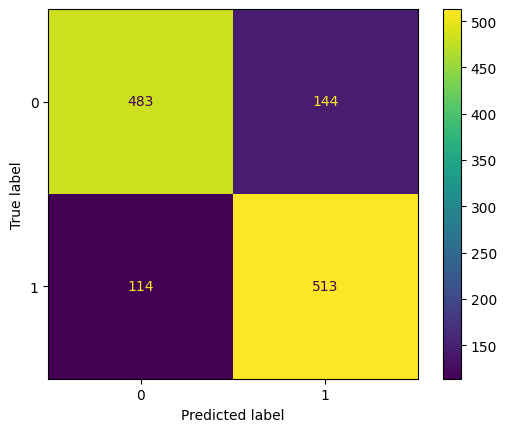

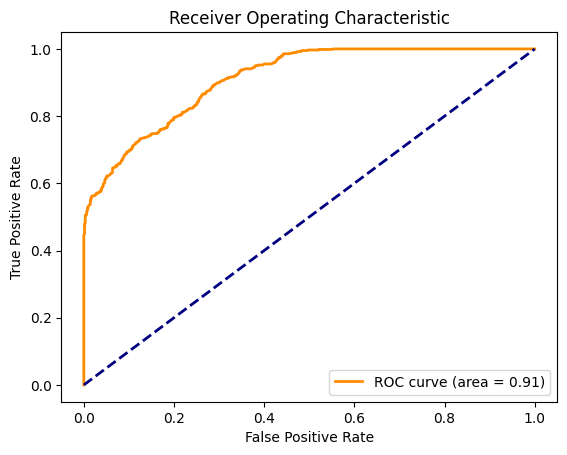

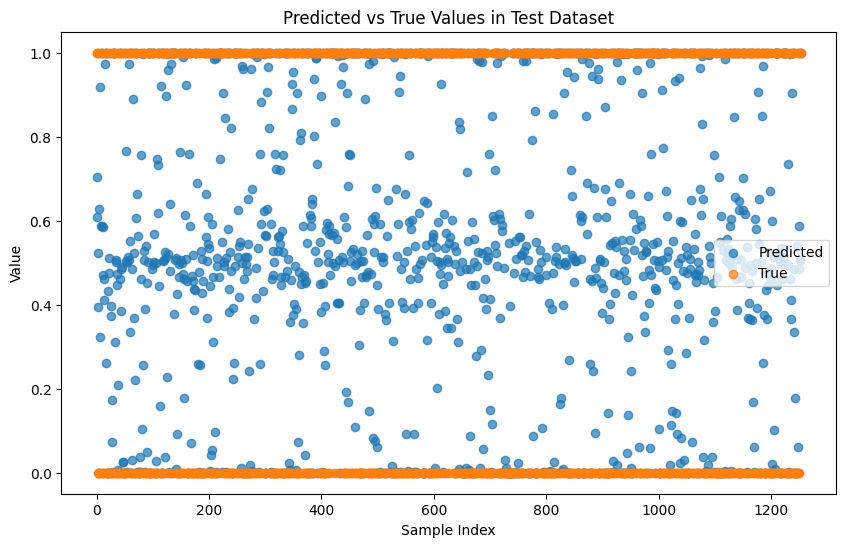

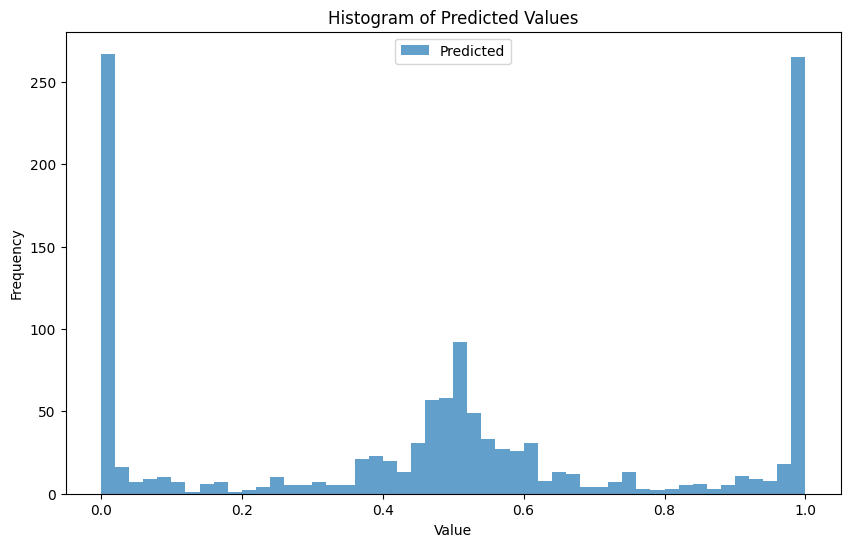

ValueError: 'c' argument has 1254 elements, which is inconsistent with 'x' and 'y' with size 844.

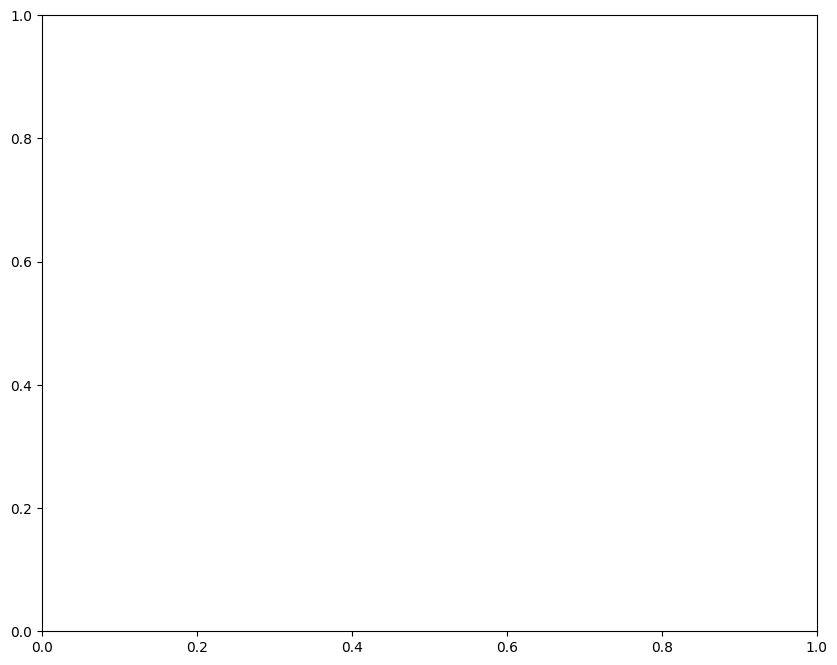

In [10]:
evaluate_model(model, test_data, random_seed=42)